# Module 3.A - Descriptive Statistics (NYC 311)

This notebook uses the NYC 311 request-level feature table built in Module 2.  

**Goal:** 
Practice descriptive statistics on a real dataset *before* any modeling.  

This module will:  
1. Load the curated NYC 311 feature table from Module 2 pipeline.
2. Choose a numeric field (starting with `resolution_hours` when available)
3. Compute **central tendency** - mean/median/trimmed mean
4. Compute **spread** - std dev, IQR, quantiles
5. Use **robust statistics** - MAD, winsorization, to handle outliers
6. Produce a short narrative: what's typical, what's variable, what's riskky

In [1]:
import sys
print(sys.executable)

/home/glake/miniconda3/envs/ml/bin/python


In [2]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 140)
pd.set_option("display.width", 160)

## 3A.1 Paths (from module 2)

The module 2 pipeline wrote artifacts under `/work/m2/data/...`  

Expected inputs:  
* Raw CSV (Module 2.A): `/work/m2/data/raw/nyc311_last14d.csv`
* Feature table (Module 2.C): `/work/m2/data/warehouse/nyc311_requests_features.parquet`
* Partitioned curated outputs (Module 2.D): `/work/m2/data/warehouse/partitions/created_day=YYY-MM-DD/requests.parquet`

Prefer the **features parquet** if it exists; otherwise fallback to the **partitioned curated** outputs.

In [3]:
WORK_DIR = Path("work")
MODULE2_DIR = WORK_DIR / "m2"
DATA_DIR = MODULE2_DIR / "data"

RAW_DIR = DATA_DIR / "raw"
REF_DIR = DATA_DIR / "reference"
WH_DIR = DATA_DIR / "warehouse"

CSV_PATH = RAW_DIR / "nyc311_last14d.csv"
FEATURES_PATH = WH_DIR / "nyc311_requests_features.parquet"
PART_DIR = WH_DIR / "partitions"

print("CSV:", CSV_PATH, "| exists?", CSV_PATH.exists())
print("Features:", FEATURES_PATH, "| exists?", FEATURES_PATH.exists())
print("Partitions", PART_DIR, "| exists?", PART_DIR.exists())

CSV: work/m2/data/raw/nyc311_last14d.csv | exists? True
Features: work/m2/data/warehouse/nyc311_requests_features.parquet | exists? True
Partitions work/m2/data/warehouse/partitions | exists? True


## 3A.2 Load the Feature Table

This loader mirrors the Module 2.E pattern:
* if `nyc311_requests_features.parquet` exists (from 2.C), use it
* else, load and concatenate partitioned `requests.parquet` files (from 2.D)

In [4]:
def load_features() -> pd.DataFrame:
    if FEATURES_PATH.exists():
        df = pd.read_parquet(FEATURES_PATH)
        df["_source"] = "2.C_features_parquet"
        return df

    if PART_DIR.exists():
        parts = sorted(PART_DIR.glob("created_day=*/requests.parquet"))
        if not parts:
            raise FileNotFoundError("No partitions found in warehouse/partitions/")
        df = pd.concat([pd.read_parquet(p) for p in parts], ignore_index=True)
        df["_source"] = "2.D_partitioned_curated"
        return df

    raise FileNotFoundError(
        "No features parquet and no partitions found. Run Module 2.C or 2.D first."
    )

df = load_features()
print("Loaded:", df["_source"].iloc[0])
print("Shape:", df.shape)
df.head(5)

Loaded: 2.C_features_parquet
Shape: (50000, 24)


,unique_key,created_date,created_day,created_hour,dayofweek,is_weekend,agency,borough_norm,complaint_topk,zip_missing,kw_noise,kw_rodent,kw_water,street_number,n_requests,closed_rate,median_resolution_hours,agency_n_requests,agency_closed_rate,agency_median_resolution,status,is_closed,resolution_hours,_source
0,67720523,2026-01-30 01:51:21,2026-01-30,1,4,0,NYPD,<NA>,other,1,1,0,0,<NA>,280,0.435714,0.480972,11651,0.981890,1.277778,Unspecified,0,NaN,2.C_features_parquet
1,67746090,2026-01-30 01:51:04,2026-01-30,1,4,0,DOE,BROOKLYN,other,0,0,0,0,911,280,0.435714,0.480972,144,0.520833,7.605000,In Progress,0,NaN,2.C_features_parquet
2,67758820,2026-01-30 01:50:53,2026-01-30,1,4,0,NYPD,MANHATTAN,noise - residential,0,1,0,0,936,280,0.435714,0.480972,11651,0.981890,1.277778,In Progress,0,NaN,2.C_features_parquet
3,67707975,2026-01-30 01:50:52,2026-01-30,1,4,0,NYPD,STATEN ISLAND,noise - residential,0,1,0,0,190,280,0.435714,0.480972,11651,0.981890,1.277778,In Progress,0,NaN,2.C_features_parquet
4,67771794,2026-01-30 01:50:32,2026-01-30,1,4,0,TLC,QUEENS,other,0,0,0,0,<NA>,280,0.435714,0.480972,246,0.117886,16.582778,In Progress,0,NaN,2.C_features_parquet


## A.3 Normalize a Few Types

Artifacts differ slightly across 2.C vs 2.D. We normalize the fields we need for EDA
* timestamps
* `created_day`
* `status`
* `is_closed` - derived if missing
* `resolution_hours` - numeric

We will work with `df2` as the normalized dataframe

In [5]:
df2 = df.copy()

# timestamps
if "created_date" in df2.columns and not np.issubdtype(df2["created_date"].dtype, np.datetime64):
    df2["created_date"] = pd.to_datetime(df2["created_date"], errors="coerce")

if "closed_date" in df2.columns and not np.issubdtype(df2["closed_date"].dtype, np.datetime64):
    df2["closed_date"] = pd.to_datetime(df2["closed_date"], errors="coerce")

# created_day
if "created_day" in df2.columns:
    if df2["created_day"].dtype == "object":
        df2["created_day"] = pd.to_datetime(df2["created_day"], errors="coerce").dt.date
else:
    if "created_date" in df2.columns:
        df2["created_day"] = df2["created_date"].dt.date

# Add created_dow
df2["created_dow"] = df2["created_date"].dt.dayofweek

# status normalization
if "status" in df2.columns:
    df2["status"] = df2["status"].astype("string").str.strip().str.title()

# is_closed
if "is_closed" not in df2.columns and "status" in df2.columns:
    df2["is_closed"] = (df2["status"] == "Closed").astype(int)

# resolution_hours
if "resolution_hours" in df2.columns:
    df2["resolution_hours"] = pd.to_numeric(df2["resolution_hours"], errors="coerce")

print("Example columns present:", [c for c in ["unique_key","created_date","created_day","agency","status","is_closed","resolution_hours"] if c in df2.columns])
df2.head(3)

Example columns present: ['unique_key', 'created_date', 'created_day', 'agency', 'status', 'is_closed', 'resolution_hours']


,unique_key,created_date,created_day,created_hour,dayofweek,is_weekend,agency,borough_norm,complaint_topk,zip_missing,kw_noise,kw_rodent,kw_water,street_number,n_requests,closed_rate,median_resolution_hours,agency_n_requests,agency_closed_rate,agency_median_resolution,status,is_closed,resolution_hours,_source,created_dow
0,67720523,2026-01-30 01:51:21,2026-01-30,1,4,0,NYPD,<NA>,other,1,1,0,0,<NA>,280,0.435714,0.480972,11651,0.981890,1.277778,Unspecified,0,NaN,2.C_features_parquet,4
1,67746090,2026-01-30 01:51:04,2026-01-30,1,4,0,DOE,BROOKLYN,other,0,0,0,0,911,280,0.435714,0.480972,144,0.520833,7.605000,In Progress,0,NaN,2.C_features_parquet,4
2,67758820,2026-01-30 01:50:53,2026-01-30,1,4,0,NYPD,MANHATTAN,noise - residential,0,1,0,0,936,280,0.435714,0.480972,11651,0.981890,1.277778,In Progress,0,NaN,2.C_features_parquet,4


### Cache for Module 3  

To avoid repeating normalization code across notebooks, we will write a **normalized** feature table to:  
* `/work/m3/data/nyc311_features_norm.parquet`

Module 3.B and later notebooks can load this file directly


In [8]:
M3_DIR = Path("work/m3")
M3_DATA_DIR = M3_DIR / "data"
M3_DATA_DIR.mkdir(parents=True, exist_ok=True)

NORM_PATH = M3_DATA_DIR / "nyc311_features_norm.parquet"
df2.to_parquet(NORM_PATH, index=False)

print("Wrote normalized feature table to:")
print(NORM_PATH)
print("Rows:", len(df2), "Cols:", df2.shape[1])

Wrote normalized feature table to:
work/m3/data/nyc311_features_norm.parquet
Rows: 50000 Cols: 25


## A.4 Choose a Numeric Column for Descriptive Stats

For NYC 311, **resolution time** is a natural first numeric variable.  

We will use:
* `resolution_hours` if present (common in 2.C features)
* otherwise compute it from `closed_date - created_date` when possible

We will also create a filtered series:
* closed requests only
* non-negative durations
* drop extreme values for "typical behavior" summaries, but keep them around for tail-risk discussion

In [9]:
df3 = df2.copy()

# Calculate resolution hours (if not present)
if "resolution_hours" not in df3.columns:
    if "created_date" in df3.columns and "closed_date" in df3.columns:
        df3["resolutions_hours"] = (df3["closed_date"] - df3["created_date"]).dt.total_second() / 3600
    else:
        raise ValueError("No resolution_hours column and not enough timestamp columns to compute it.")

# Basic mask: closed + finite durations
is_closed = df3["is_closed"] == 1 if "is_closed" in df3.columns else pd.Series([True]*len(df3))
dur = pd.to_numeric(df3["resolution_hours"], errors="coerce")

mask = is_closed & dur.notna()
dur_closed = dur.loc[mask]

print("Closed rows with duration:", len(dur_closed), "out of", len(df3))
print("Min hours:", float(dur_closed.min()), "Max hours:", float(dur_closed.max()))

# Common anomalies
n_negative = int((dur_closed < 0).sum())
print("Negative durations (should be 0):", n_negative)


Closed rows with duration: 18894 out of 50000
Min hours: 0.0 Max hours: 66.0663888888889
Negative durations (should be 0): 0


### Quick Look: distribution shape  

Descriptive stats should be paired with a plot. We will start with:
* Histogram (linear scale)
* Histogram (log scale via log1p) - to see the tail more clearly

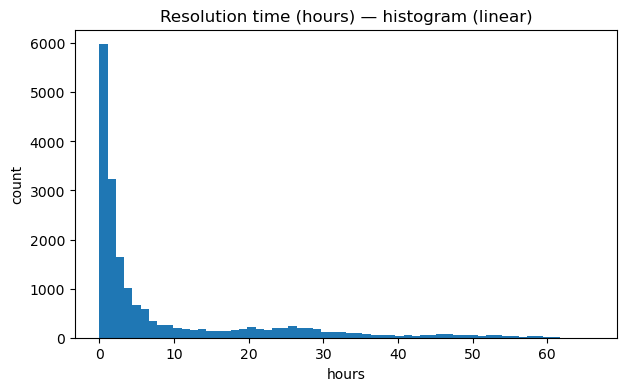

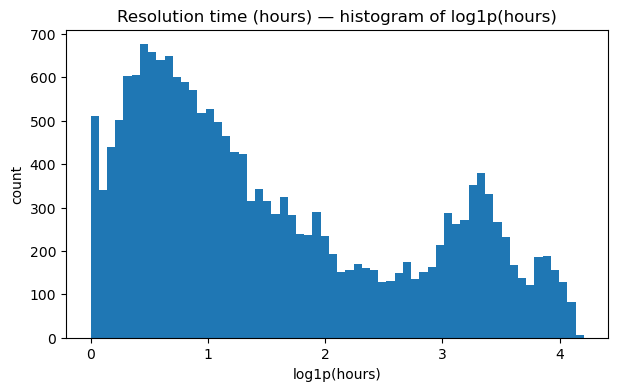

count    18894.000000
mean         8.827548
std         12.997412
min          0.000000
50%          2.318889
75%         11.172986
90%         28.556333
95%         38.251319
99%         54.333253
max         66.066389
Name: resolution_hours, dtype: float64

In [23]:
x = dur_closed.copy()

plt.figure(figsize=(7,4))
plt.hist(x.clip(lower=0), bins=60)
plt.title("Resolution time (hours) — histogram (linear)")
plt.xlabel("hours")
plt.ylabel("count")
plt.show()

plt.figure(figsize=(7,4))
plt.hist(np.log1p(x.clip(lower=0)), bins=60)
plt.title("Resolution time (hours) — histogram of log1p(hours)")
plt.xlabel("log1p(hours)")
plt.ylabel("count")
plt.show()

# Pandas built in method for statistical summaries of a series or DataFrame
# Also include specific quantities listed
x.describe(percentiles=[0.5,0.75,0.9,0.95,0.99])


## A.5 Central Tendency (Mean vs Median vs Trimmed Mean)

The mean answers "What's the average", but it is pulled by extreme values.  

A good EDA habit:
* report both **mean** and **median**
* add a **trimmed mean** (drop top/bottom p%) to estimate typical under contamination

In [11]:
def trimmed_mean(x: pd.Series, trim: float = 0.05) -> float:
    x2 = x.dropna().sort_values()
    n = len(x2)
    k = int(n * trim)
    if n- 2*k <= 0:
        return float(x2.mean())
    return float(x2.iloc[k:n-k].mean())

x = dur_closed.copy()
x = x[x >= 0]

summary_center = pd.DataFrame({
    "metric": ["mean", "median", "trimmed_mean_5pct"],
    "value_hours": [float(x.mean()), float(x.median()), trimmed_mean(x, 0.05)]
})
summary_center

,metric,value_hours
0,mean,8.827548
1,median,2.318889
2,trimmed_mean_5pct,7.113586


### Visual: Mean and Median Markers  

Plot a histogram and mark the mean and median with vertical lines

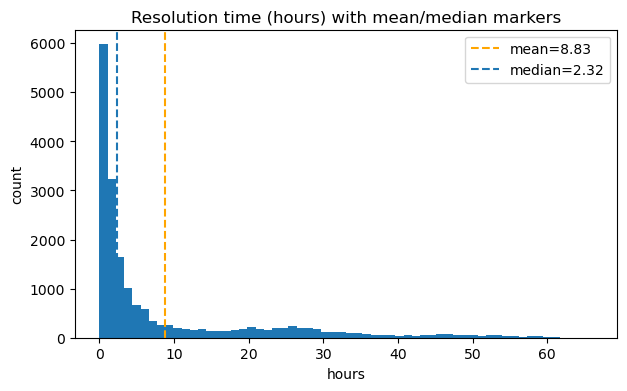

In [12]:
plt.figure(figsize=(7,4))
plt.hist(x, bins=60)
plt.axvline(x.mean(), linestyle="--", c="orange", label=f"mean={x.mean():.2f}")
plt.axvline(x.median(), linestyle="--", label=f"median={x.median():.2f}")
plt.title("Resolution time (hours) with mean/median markers")
plt.xlabel("hours")
plt.ylabel("count")
plt.legend()
plt.show()

## A.6 Spread and Variability

Useful spread summaries for skewed distributions:  
* **std dev** - sensitive to tails
* **IQR** - robust
* **Quantiles** - p50/p90/p95/p99, often matter more than the mean


In [13]:
def iqr(x: pd.Series) -> float:
    return float(x.quantile(0.75) - x.quantile(0.25))

spread = {
    "std_hours": float(x.std(ddof=1)),
    "iqr_hours": iqr(x),
    "p50_hours": float(x.quantile(0.50)),
    "p90_hours": float(x.quantile(0.90)),
    "p95_hours": float(x.quantile(0.95)),
    "p99_hours": float(x.quantile(0.99)),
    "max_hours": float(x.max()),
}

pd.DataFrame([spread]).T.rename(columns={0:"value"})

,value
std_hours,12.997412
iqr_hours,10.344653
p50_hours,2.318889
p90_hours,28.556333
p95_hours,38.251319
p99_hours,54.333253
max_hours,66.066389


### Visual: Boxplot (Tail sensitivity)  

Boxplots show median + IQR and make outliers explicit

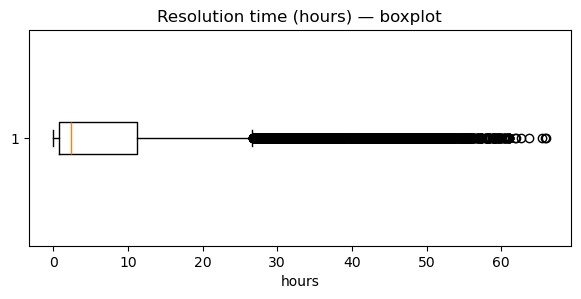

Tip: if the tail dominates, consider plotting on a log scale or trimming for visualization only.


In [14]:
plt.figure(figsize=(7,2.8))
plt.boxplot(x, vert=False, showfliers=True)
plt.title("Resolution time (hours) — boxplot")
plt.xlabel("hours")
plt.show()

print("Tip: if the tail dominates, consider plotting on a log scale or trimming for visualization only.")

## A.7 Robust Statistics (MAD + winsorization)

Robust statistics are dosigned to fail gracefully when the data is contaminated by:
* logging errors
* rare but real events
* unit glitches
* extreme long-tail cases

We will compute
* MAD - median absolute deviation
* Winsorized version of the data (clip to percentiles) and compare how summaries change

In [15]:
def mad(x: pd.Series) -> float:
    x2 = x.dropna()
    med = x2.median()
    return float((x2 - med).abs().median())

def winsorize(x: pd.Series, lower_q=0.01, upper_q=0.99) -> pd.Series:
    lo = x.quantile(lower_q)
    hi = x.quantile(upper_q)
    return x.clip(lower=float(lo), upper=float(hi))

x_w = winsorize(x, 0.05, 0.95)

robust_summary = pd.DataFrame({
    "stat": ["mean", "median", "std", "IQR", "MAD", "p95", "p99", "max"],
    "raw_hours": [
        float(x.mean()),
        float(x.median()),
        float(x.std(ddof=1)),
        iqr(x),
        mad(x),
        float(x.quantile(0.95)),
        float(x.quantile(0.99)),
        float(x.max()),
    ],
    "winsor_hours": [
        float(x_w.mean()),
        float(x_w.median()),
        float(x_w.std(ddof=1)),
        iqr(x_w),
        mad(x_w),
        float(x_w.quantile(0.95)),
        float(x_w.quantile(0.99)),
        float(x_w.max()),
    ],
})
robust_summary


,stat,raw_hours,winsor_hours
0,mean,8.827548,8.322420
1,median,2.318889,2.318889
2,std,12.997412,11.469387
3,IQR,10.344653,10.344653
4,MAD,1.919861,1.919861
5,p95,38.251319,38.251003
6,p99,54.333253,38.251319
7,max,66.066389,38.251319


### Visual: Raw vs Winsorized - for interpretation  

Winsorization is **not** "cleaning away the truth", it is a way to ask:  

What do the summaries look like if we limit extreme influence?


We will compare histograms

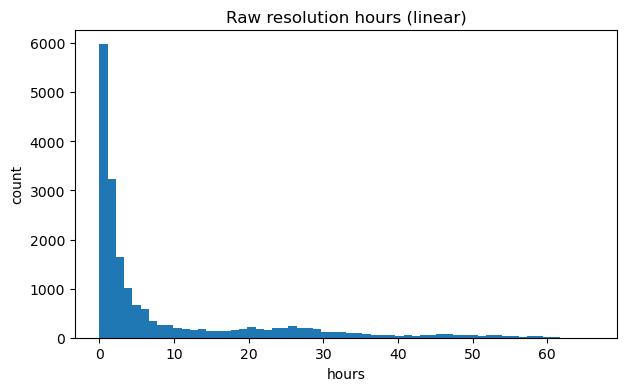

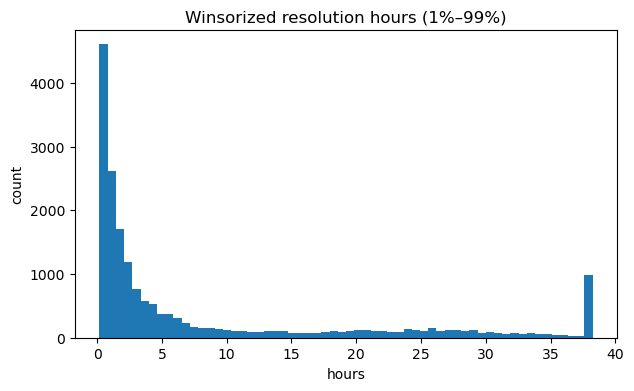

In [16]:
plt.figure(figsize=(7,4))
plt.hist(x, bins=60)
plt.title("Raw resolution hours (linear)")
plt.xlabel("hours")
plt.ylabel("count")
plt.show()

plt.figure(figsize=(7,4))
plt.hist(x_w, bins=60)
plt.title("Winsorized resolution hours (1%–99%)")
plt.xlabel("hours")
plt.ylabel("count")
plt.show()

## A.8 Group Summaries (Agency-level typical vs tail)

Descriptive statistics get much more useful when you compare groups. We will compute, for the most common agencies:
* count
* mean
* median
* p90/ p95

Then we will visualize the distributions for the top few agencies.

In [17]:
if "agency" not in df3.columns:
    raise ValueError("No 'agency' column found in the feature table")

tmp = df3.loc[mask].copy()
tmp["resolution_hours"] = dur_closed.values

# Keep plausible non-negative durations for summaries
tmp = tmp.loc[tmp["resolution_hours"].notna() & (tmp["resolution_hours"] >= 0)].copy()

top_agencies = tmp["agency"].astype("string").value_counts().head(8).index.tolist()

def q(x, p):
    return float(x.quantile(p))

group_stats = (
    tmp.loc[tmp["agency"].isin(top_agencies)]
       .groupby("agency")["resolution_hours"]
       .agg(
           n="count",
           mean="mean",
           median="median",
           p90=lambda s: q(s, 0.90),
           p95=lambda s: q(s, 0.95),
       )
       .sort_values("n", ascending=False)
)

group_stats

,n,mean,median,p90,p95
agency,,,,,
NYPD,11440,2.065904,1.278056,4.785667,6.402319
HPD,4458,23.999943,23.354861,46.873194,52.485792
DSNY,794,18.759539,20.099722,33.866306,46.265167
DOT,755,8.385227,2.448611,22.958833,29.547472
DEP,711,6.089803,1.033333,21.366667,28.458333
DHS,227,18.050852,12.941389,45.522667,49.234139
DOB,147,9.495754,8.230000,29.426111,34.048278
DOHMH,125,13.816304,14.663611,24.342278,24.479667


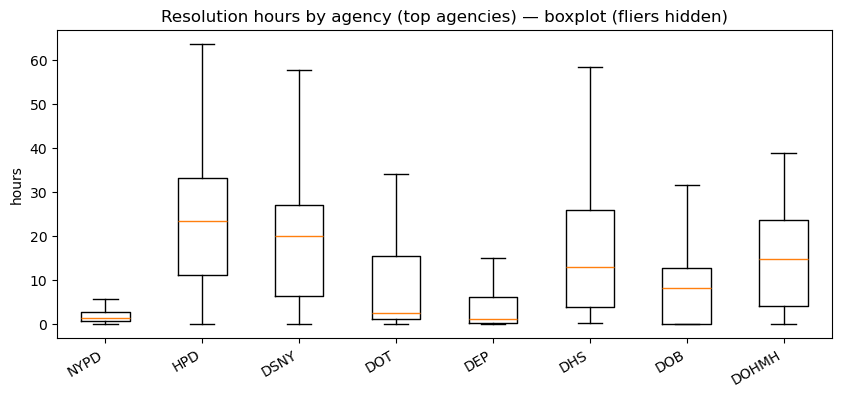

Note: fliers hidden here to keep the plot readable. Tail risk still exists—use quantiles to quantify it.


In [20]:
# Boxplot by agency (top agencies only)
data = [tmp.loc[tmp["agency"] == a, "resolution_hours"] for a in top_agencies]

plt.figure(figsize=(10,4))
plt.boxplot(data, tick_labels=[str(a) for a in top_agencies], showfliers=False)
plt.title("Resolution hours by agency (top agencies) — boxplot (fliers hidden)")
plt.ylabel("hours")
plt.xticks(rotation=30, ha="right")
plt.show()

print("Note: fliers hidden here to keep the plot readable. Tail risk still exists—use quantiles to quantify it.")

## A.9 Deliverable: a short narrative

Write 5–8 bullet points that answer:

1) **What is “typical” resolution time overall? (median + context)**  
    The resolution time comes from the median of the `resolution_hours` field. From A.4, we can see that when running .describe, the median (p50) is **2.318889**
    
2) **How variable is it? (IQR and p90/p95)**  
    *How much do the resolution times differ from each other*. This is asking about the spread or dispersion of the data.  
    IQR = 0.75 - 0.25 (The range that contains the middle 50% of the data.  
    From A.4, we can see the IQR = 10.34 hours, p90 = 28.56, p95 = 38.25
    
3) **How heavy is the tail? (p99 vs median, max)**  
    How extreme are the worst-case resolution times compared to typical?  
    From A.4, we can see that p99 = 54.33, median = 2.32, max = 66.07
    
4) **Which agencies look different, and how? (median vs p95)**
    median resolution time -> typical case
    p95 -> bad, but not extreme, case
    From A.8, we can see that NYPD is the fastest and HPD is the slowest.

5) **What would you investigate next? (data issues vs real effects)**
    We need to determine if there are issues that are caused by bad data vs real issues    

Use numbers. Be explicit about what could be misleading.

### Optional: quick “sanity checks” you should always run

Even in an EDA notebook, act like an engineer:
- Are there negative durations?  
- Are there impossible timestamps?  
- Do missing values cluster by agency/category?  
- Are there sudden shifts by day?

You’ll formalize these as validation checks again in later modules — but build the habit now.